This code is a template for usage of machine learning model in PM2.5 stimation with Aerosol Optical Depth and meteorological data. We used it for different datasets in different cities.

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.utils import resample
import missingno
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.neighbors import KNeighborsRegressor


%matplotlib inline
%config InlineBackend.figure_format='retina'
COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(COLORS_PALETTE))
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

rcParams['figure.figsize'] = 22, 12

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



In [148]:
# The name of dataset should be used here: replace it with DATASET.csv
#The data should contain a column for DATE

df = pd.read_csv(
    "../data/SHARIF_lag.csv",
    parse_dates=['DATE'],
    index_col = "DATE"
)



In [149]:
df_cp = df.copy()

In [150]:
df_cp

,M,BL,D2M,LAIH,LAII,SP,T2M,PREC,U10,V10,AOD,PM25lag2,PM25lag,PM25
DATE,,,,,,,,,,,,,,
2017-01-01,1,638.587784,280.794095,0,0,101385.8884,293.573391,0.000000,2.664590,-5.781169,0.477,20.0,45.3,41.9
2017-01-02,1,402.275446,282.039817,0,0,101269.6047,293.677911,0.000000,1.147606,-3.386943,0.167,15.5,20.0,45.3
2017-01-03,1,818.096724,278.430237,0,0,101566.5412,292.466772,0.000000,2.593256,-5.750343,0.387,18.8,15.5,20.0
2017-01-04,1,898.922517,276.129851,0,0,101552.5793,290.399539,0.000000,2.599039,-4.659894,0.282,12.1,18.8,15.5
2017-01-05,1,992.716151,276.286929,0,0,101841.5845,290.853716,0.000000,4.991318,-6.992468,0.314,45.8,12.1,18.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-13,1,770.604662,290.912459,0,0,101344.3304,299.380716,0.000000,0.385419,-3.299021,0.420,33.5,43.9,30.3
2022-11-14,1,667.117035,287.984404,0,0,101195.4688,298.802623,0.000000,-0.619370,-2.470938,NaN,38.0,33.5,43.9
2022-11-15,1,453.594084,285.323060,0,0,101182.5557,298.790771,0.000000,-4.039251,-1.176620,0.460,42.6,38.0,33.5


In [151]:


df = df.dropna()



In [152]:


df.shape



(2077, 14)

In [153]:
df

,M,BL,D2M,LAIH,LAII,SP,T2M,PREC,U10,V10,AOD,PM25lag2,PM25lag,PM25
DATE,,,,,,,,,,,,,,
2017-01-01,1,638.587784,280.794095,0,0,101385.8884,293.573391,0.000000,2.664590,-5.781169,0.477,20.0,45.3,41.9
2017-01-02,1,402.275446,282.039817,0,0,101269.6047,293.677911,0.000000,1.147606,-3.386943,0.167,15.5,20.0,45.3
2017-01-03,1,818.096724,278.430237,0,0,101566.5412,292.466772,0.000000,2.593256,-5.750343,0.387,18.8,15.5,20.0
2017-01-04,1,898.922517,276.129851,0,0,101552.5793,290.399539,0.000000,2.599039,-4.659894,0.282,12.1,18.8,15.5
2017-01-05,1,992.716151,276.286929,0,0,101841.5845,290.853716,0.000000,4.991318,-6.992468,0.314,45.8,12.1,18.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-09,1,518.220704,288.104937,0,0,100769.1387,300.808437,0.000000,0.547368,0.628770,0.467,22.2,24.5,50.9
2022-11-10,1,408.057828,295.102264,0,0,101096.3589,299.604302,0.000000,-3.783797,-4.177546,0.336,17.5,22.2,24.5
2022-11-12,1,278.251860,292.967291,0,0,101437.0166,298.886131,0.000256,-1.205791,-2.987264,0.442,43.9,30.3,17.5


In [154]:
#Write all column you want to use as your dataset here. Use PM25 as output, and other as input.

selected_cols = ['M','BL','D2M','SP','T2M','U10','V10','AOD','PM25lag','PM25lag2','PM25']

df = df[selected_cols]

In [155]:


df



,M,BL,D2M,SP,T2M,U10,V10,AOD,PM25lag,PM25lag2,PM25
DATE,,,,,,,,,,,
2017-01-01,1,638.587784,280.794095,101385.8884,293.573391,2.664590,-5.781169,0.477,45.3,20.0,41.9
2017-01-02,1,402.275446,282.039817,101269.6047,293.677911,1.147606,-3.386943,0.167,20.0,15.5,45.3
2017-01-03,1,818.096724,278.430237,101566.5412,292.466772,2.593256,-5.750343,0.387,15.5,18.8,20.0
2017-01-04,1,898.922517,276.129851,101552.5793,290.399539,2.599039,-4.659894,0.282,18.8,12.1,15.5
2017-01-05,1,992.716151,276.286929,101841.5845,290.853716,4.991318,-6.992468,0.314,12.1,45.8,18.8
...,...,...,...,...,...,...,...,...,...,...,...
2022-11-09,1,518.220704,288.104937,100769.1387,300.808437,0.547368,0.628770,0.467,24.5,22.2,50.9
2022-11-10,1,408.057828,295.102264,101096.3589,299.604302,-3.783797,-4.177546,0.336,22.2,17.5,24.5
2022-11-12,1,278.251860,292.967291,101437.0166,298.886131,-1.205791,-2.987264,0.442,30.3,43.9,17.5


<AxesSubplot:>

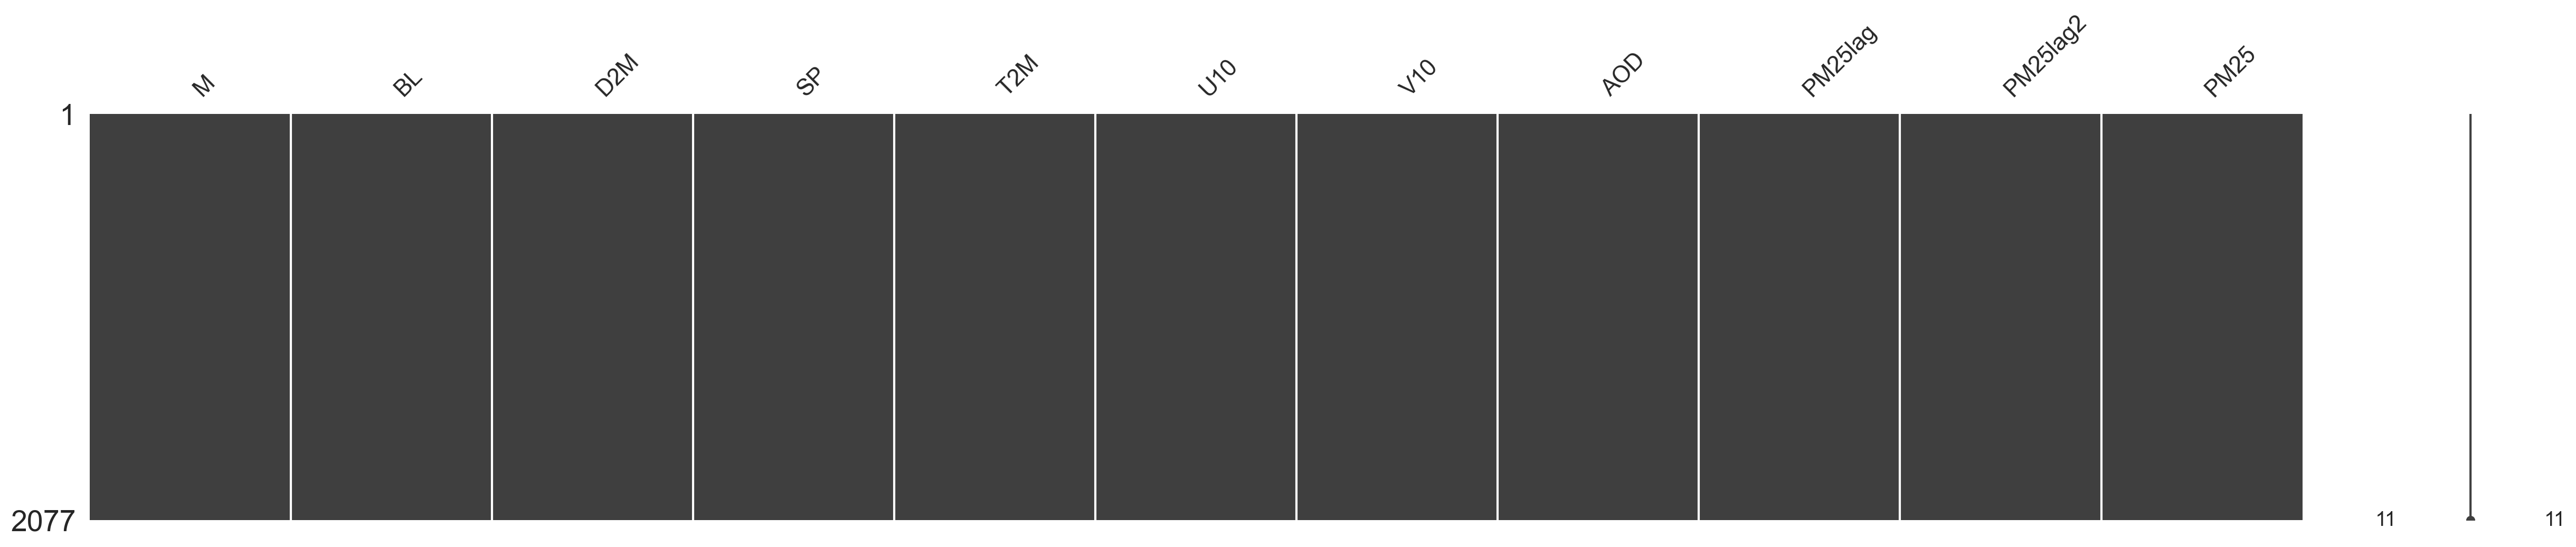

In [156]:


# Check missing values
missingno.matrix(df, figsize = (30,5))



<AxesSubplot:>

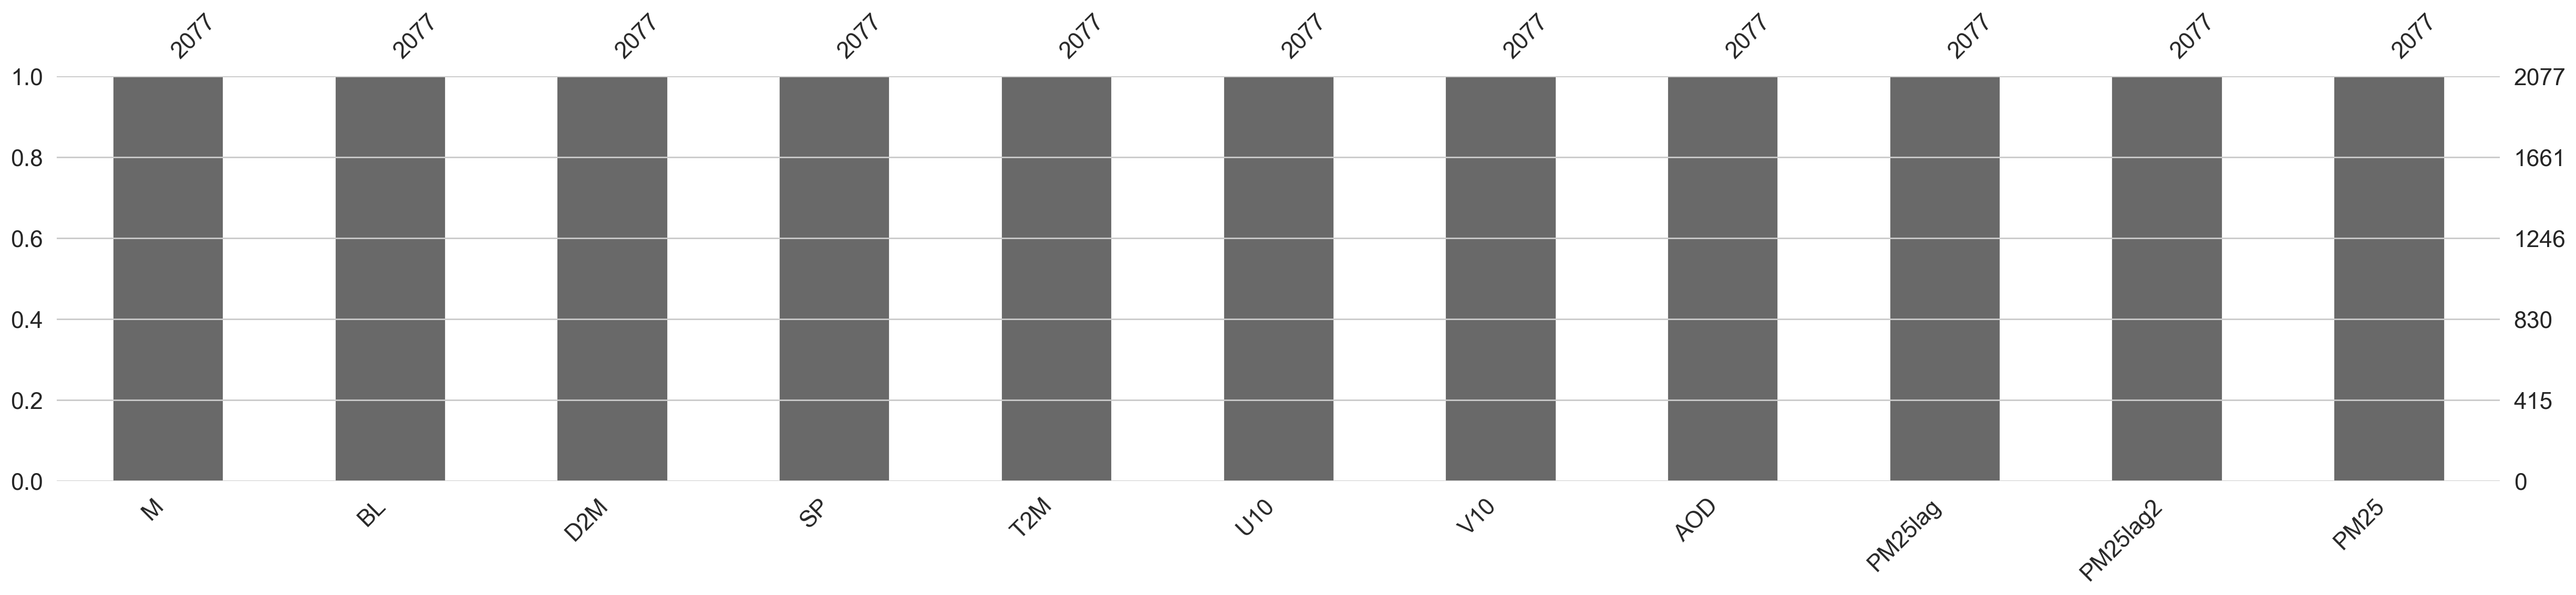

In [157]:


missingno.bar(df, sort='ascending', figsize = (30,5))



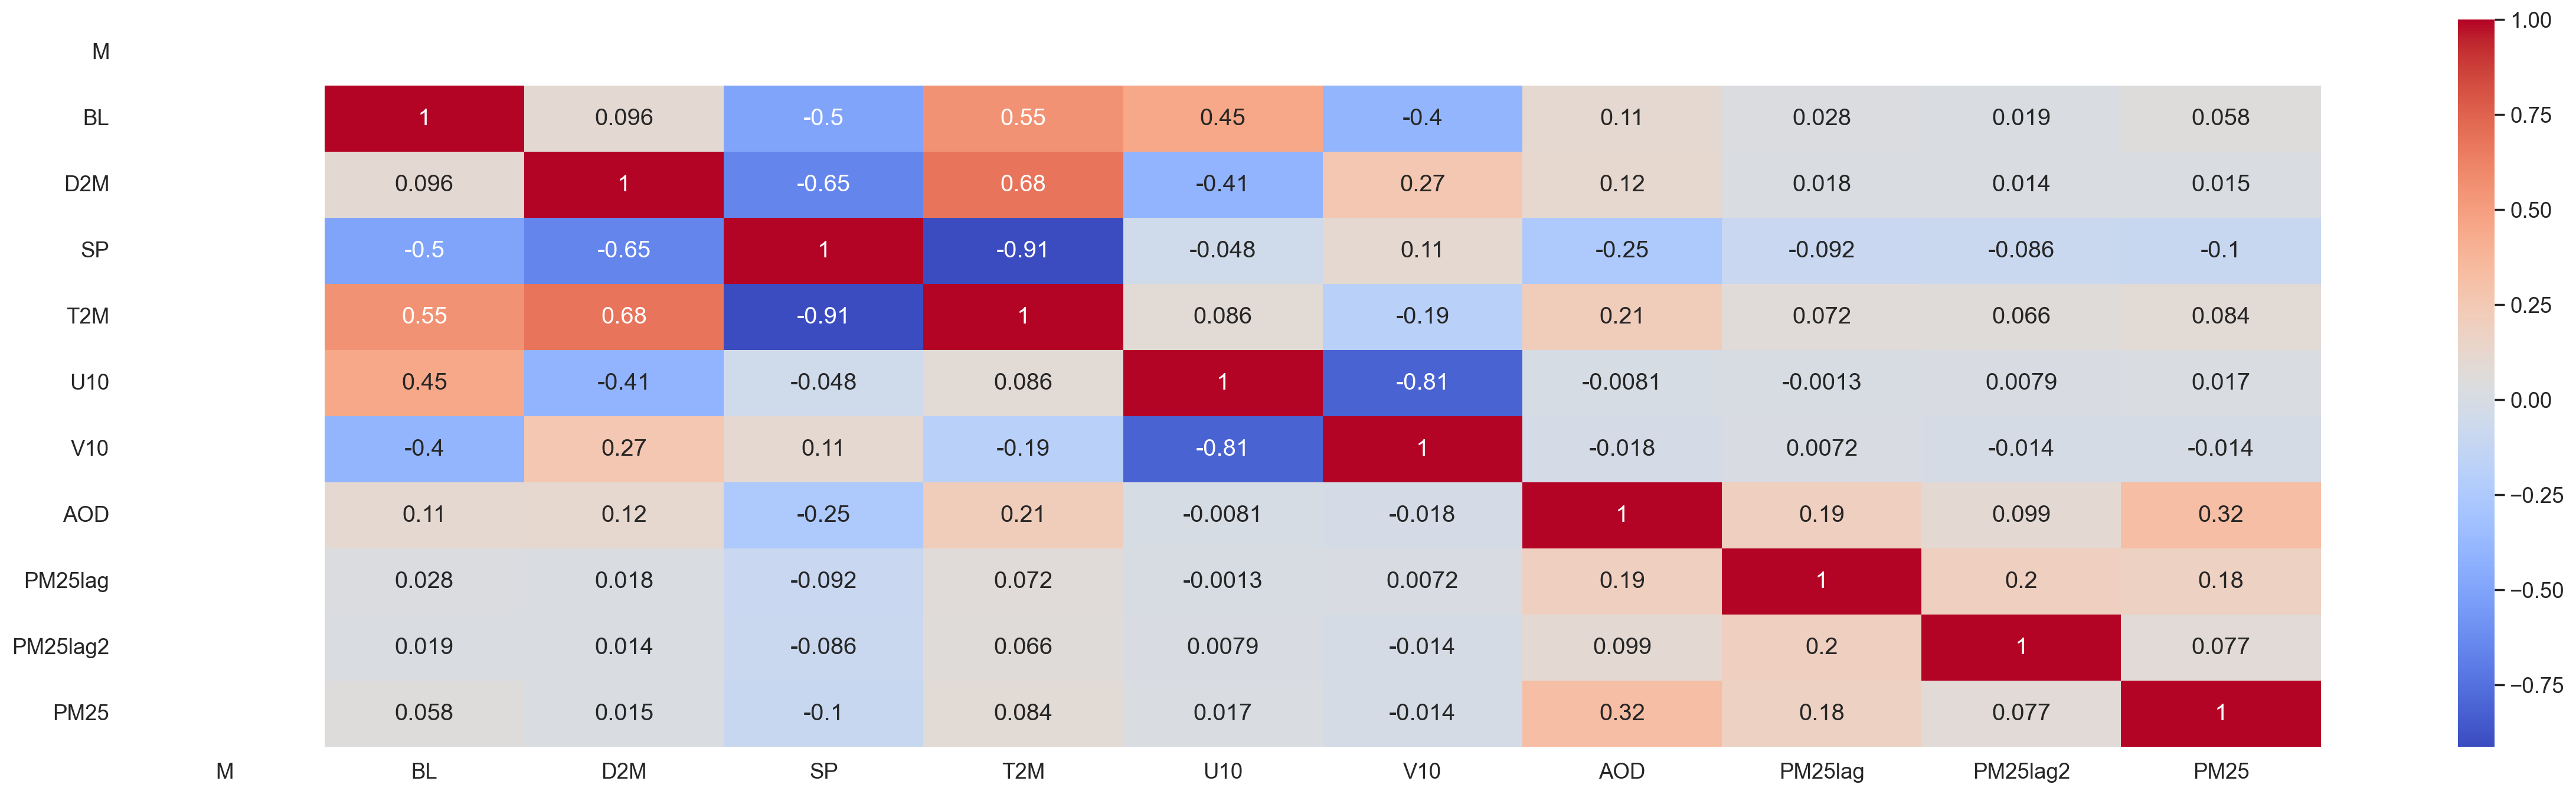

In [158]:


#check Pearson's correlation coeffcient
plt.figure(figsize=(30,8))
sns.heatmap(df.corr(),cmap='coolwarm',annot = True)
plt.show()



In [159]:
#Determine the test_size. Set PM25 as output (y)

X_train, X_test, y_train, y_test = train_test_split(df.drop('PM25', axis=1), df['PM25'], test_size=0.2, random_state=RANDOM_SEED, shuffle = True)


In [160]:


X_train.head()



,M,BL,D2M,SP,T2M,U10,V10,AOD,PM25lag,PM25lag2
DATE,,,,,,,,,,
2018-07-12,1,1262.829911,290.196313,98872.80850,315.810290,2.778661,-4.989165,1.376,278.7,168.3
2020-08-15,1,1913.773037,287.512530,99065.91561,314.211780,6.263772,-5.718467,0.406,126.3,66.5
2017-11-13,1,854.534233,276.181783,101103.70030,299.656024,4.361517,-4.932769,0.132,11.4,17.3
2018-04-03,1,622.856304,284.202359,100684.84280,300.749712,-4.870202,1.798035,0.778,47.4,27.4
2019-04-01,1,1806.246246,278.185965,100504.51770,296.590463,10.027151,-0.952085,0.743,54.8,35.3


In [161]:
y_train.head()

DATE
2018-07-12    104.0
2020-08-15     72.1
2017-11-13     13.4
2018-04-03      4.9
2019-04-01     21.6
Name: PM25, dtype: float64

In [162]:


#sclae the data using standard scalar
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

# Declare the scaling strategy
std_scaler_X = RobustScaler()
std_scaler_y = RobustScaler()

# Fit base features with training data
base_transformer = std_scaler_X.fit(X_train)

# Transform base features
X_train = base_transformer.transform(X_train)
X_test = base_transformer.transform(X_test)

# Fit label with training label
label_transformer = std_scaler_y.fit(y_train)

# Transform labels
y_train = label_transformer.transform(y_train)
y_test = label_transformer.transform(y_test)

X_train[:5]



array([[ 0.        ,  0.23320982,  0.40094377, -1.12832454,  0.61395671,
         0.54109727, -0.56807187,  2.9519231 ,  8.88432836,  4.71217712],
       [ 0.        ,  0.94233441,  0.06614412, -0.99110344,  0.52060785,
         1.08601286, -0.71195577, -0.15705128,  3.19776119,  0.95571956],
       [ 0.        , -0.21157944, -1.34735663,  0.45693784, -0.32941102,
         0.78858521, -0.5569454 , -1.03525642, -1.08955224, -0.8597786 ],
       [ 0.        , -0.4639648 , -0.34679677,  0.15929945, -0.26554241,
        -0.65484325,  0.77097443,  1.03525641,  0.25373134, -0.48708487],
       [ 0.        ,  0.82519685, -1.09733664,  0.03116119, -0.50843191,
         1.6744373 ,  0.22840359,  0.92307692,  0.52985075, -0.19557196]])

In [163]:

df_performance = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])


In [164]:
def performance(model, y_test, y_pred):
    model_name = str(model)
    model_name = model_name.split('(')
    model_name = model_name[0]
    df_temp=pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    d =[ model_name, mae , mse, rmse, r2]
    df_temp = df_temp.append(pd.Series(d,index=['Model', 'MAE', 'MSE', 'RMSE', 'R2']),ignore_index=True)
    return df_temp


In [ ]:
#linear regression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)
df_performance = df_performance.append(performance(model_lr, y_test, y_pred))


In [166]:


df_performance



,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634


In [ ]:


#SVM regressor
p_svm = {'kernel': 'rbf', 'C':2}
model_svm = SVR(**p_svm)
model_svm.fit(X_train,y_train)
y_pred = model_svm.predict(X_test)
df_performance = df_performance.append(performance(model_svm, y_test, y_pred))




In [168]:
df_performance


,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634
0,SVR,0.809214,4.230544,2.056829,0.066617


In [169]:


df_performance = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])



In [170]:


def performance(model, y_test, y_pred):
    model_name = str(model)
    model_name = model_name.split('(')
    model_name = model_name[0]
    df_temp=pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    r2 = metrics.r2_score(y_test, y_pred)
    d =[ model_name, mae , mse, rmse, r2]
    df_temp = df_temp.append(pd.Series(d,index=['Model', 'MAE', 'MSE', 'RMSE', 'R2']),ignore_index=True)
    return df_temp



In [171]:


#linear regression
model_lr = LinearRegression()
model_lr.fit(X_train,y_train)
y_pred = model_lr.predict(X_test)
df_performance = df_performance.append(performance(model_lr, y_test, y_pred))



/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/686950856.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series(d,index=['Model', 'MAE', 'MSE', 'RMSE', 'R2']),ignore_index=True)
/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/2694025402.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance = df_performance.append(performance(model_lr, y_test, y_pred))


In [172]:
df_performance


,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634


In [173]:


#SVM regressor
p_svm = {'kernel': 'rbf', 'C':5}
model_svm = SVR(**p_svm)
model_svm.fit(X_train,y_train)
y_pred = model_svm.predict(X_test)
df_performance = df_performance.append(performance(model_svm, y_test, y_pred))



/Users/negin/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/686950856.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series(d,index=['Model', 'MAE', 'MSE', 'RMSE', 'R2']),ignore_index=True)
/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/1908898022.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance = df_performance.append(performance(model_svm, y_test, y_pred))


In [174]:
df_performance


,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634
0,SVR,0.808786,4.175466,2.043396,0.078769


In [175]:
#random forest regressor
# The parameters are chosen after optimation
p_rf = {'bootstrap': True,
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400,
 'random_state': RANDOM_SEED}

model_rf = RandomForestRegressor(**p_rf)
model_rf.fit(X_train,y_train)
y_pred = model_rf.predict(X_test)
df_performance = df_performance.append(performance(model_rf, y_test, y_pred))




/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/2225130862.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train,y_train)
/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/686950856.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp = df_temp.append(pd.Series(d,index=['Model', 'MAE', 'MSE', 'RMSE', 'R2']),ignore_index=True)
/var/folders/3c/crvbk9w17pd2_5b551qb5s440000gn/T/ipykernel_96048/2225130862.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_performance = df_performance.append(performance(model_rf, y_test, y_pred))


In [176]:
df_performance

,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634
0,SVR,0.808786,4.175466,2.043396,0.078769
0,RandomForestRegressor,0.838557,3.823404,1.955353,0.156444


No handles with labels found to put in legend.


AOD         0.249578
PM25lag     0.192508
PM25lag2    0.115287
BL          0.088562
SP          0.086707
U10         0.079933
D2M         0.069723
T2M         0.065563
V10         0.052140
M           0.000000
dtype: float64
1.0


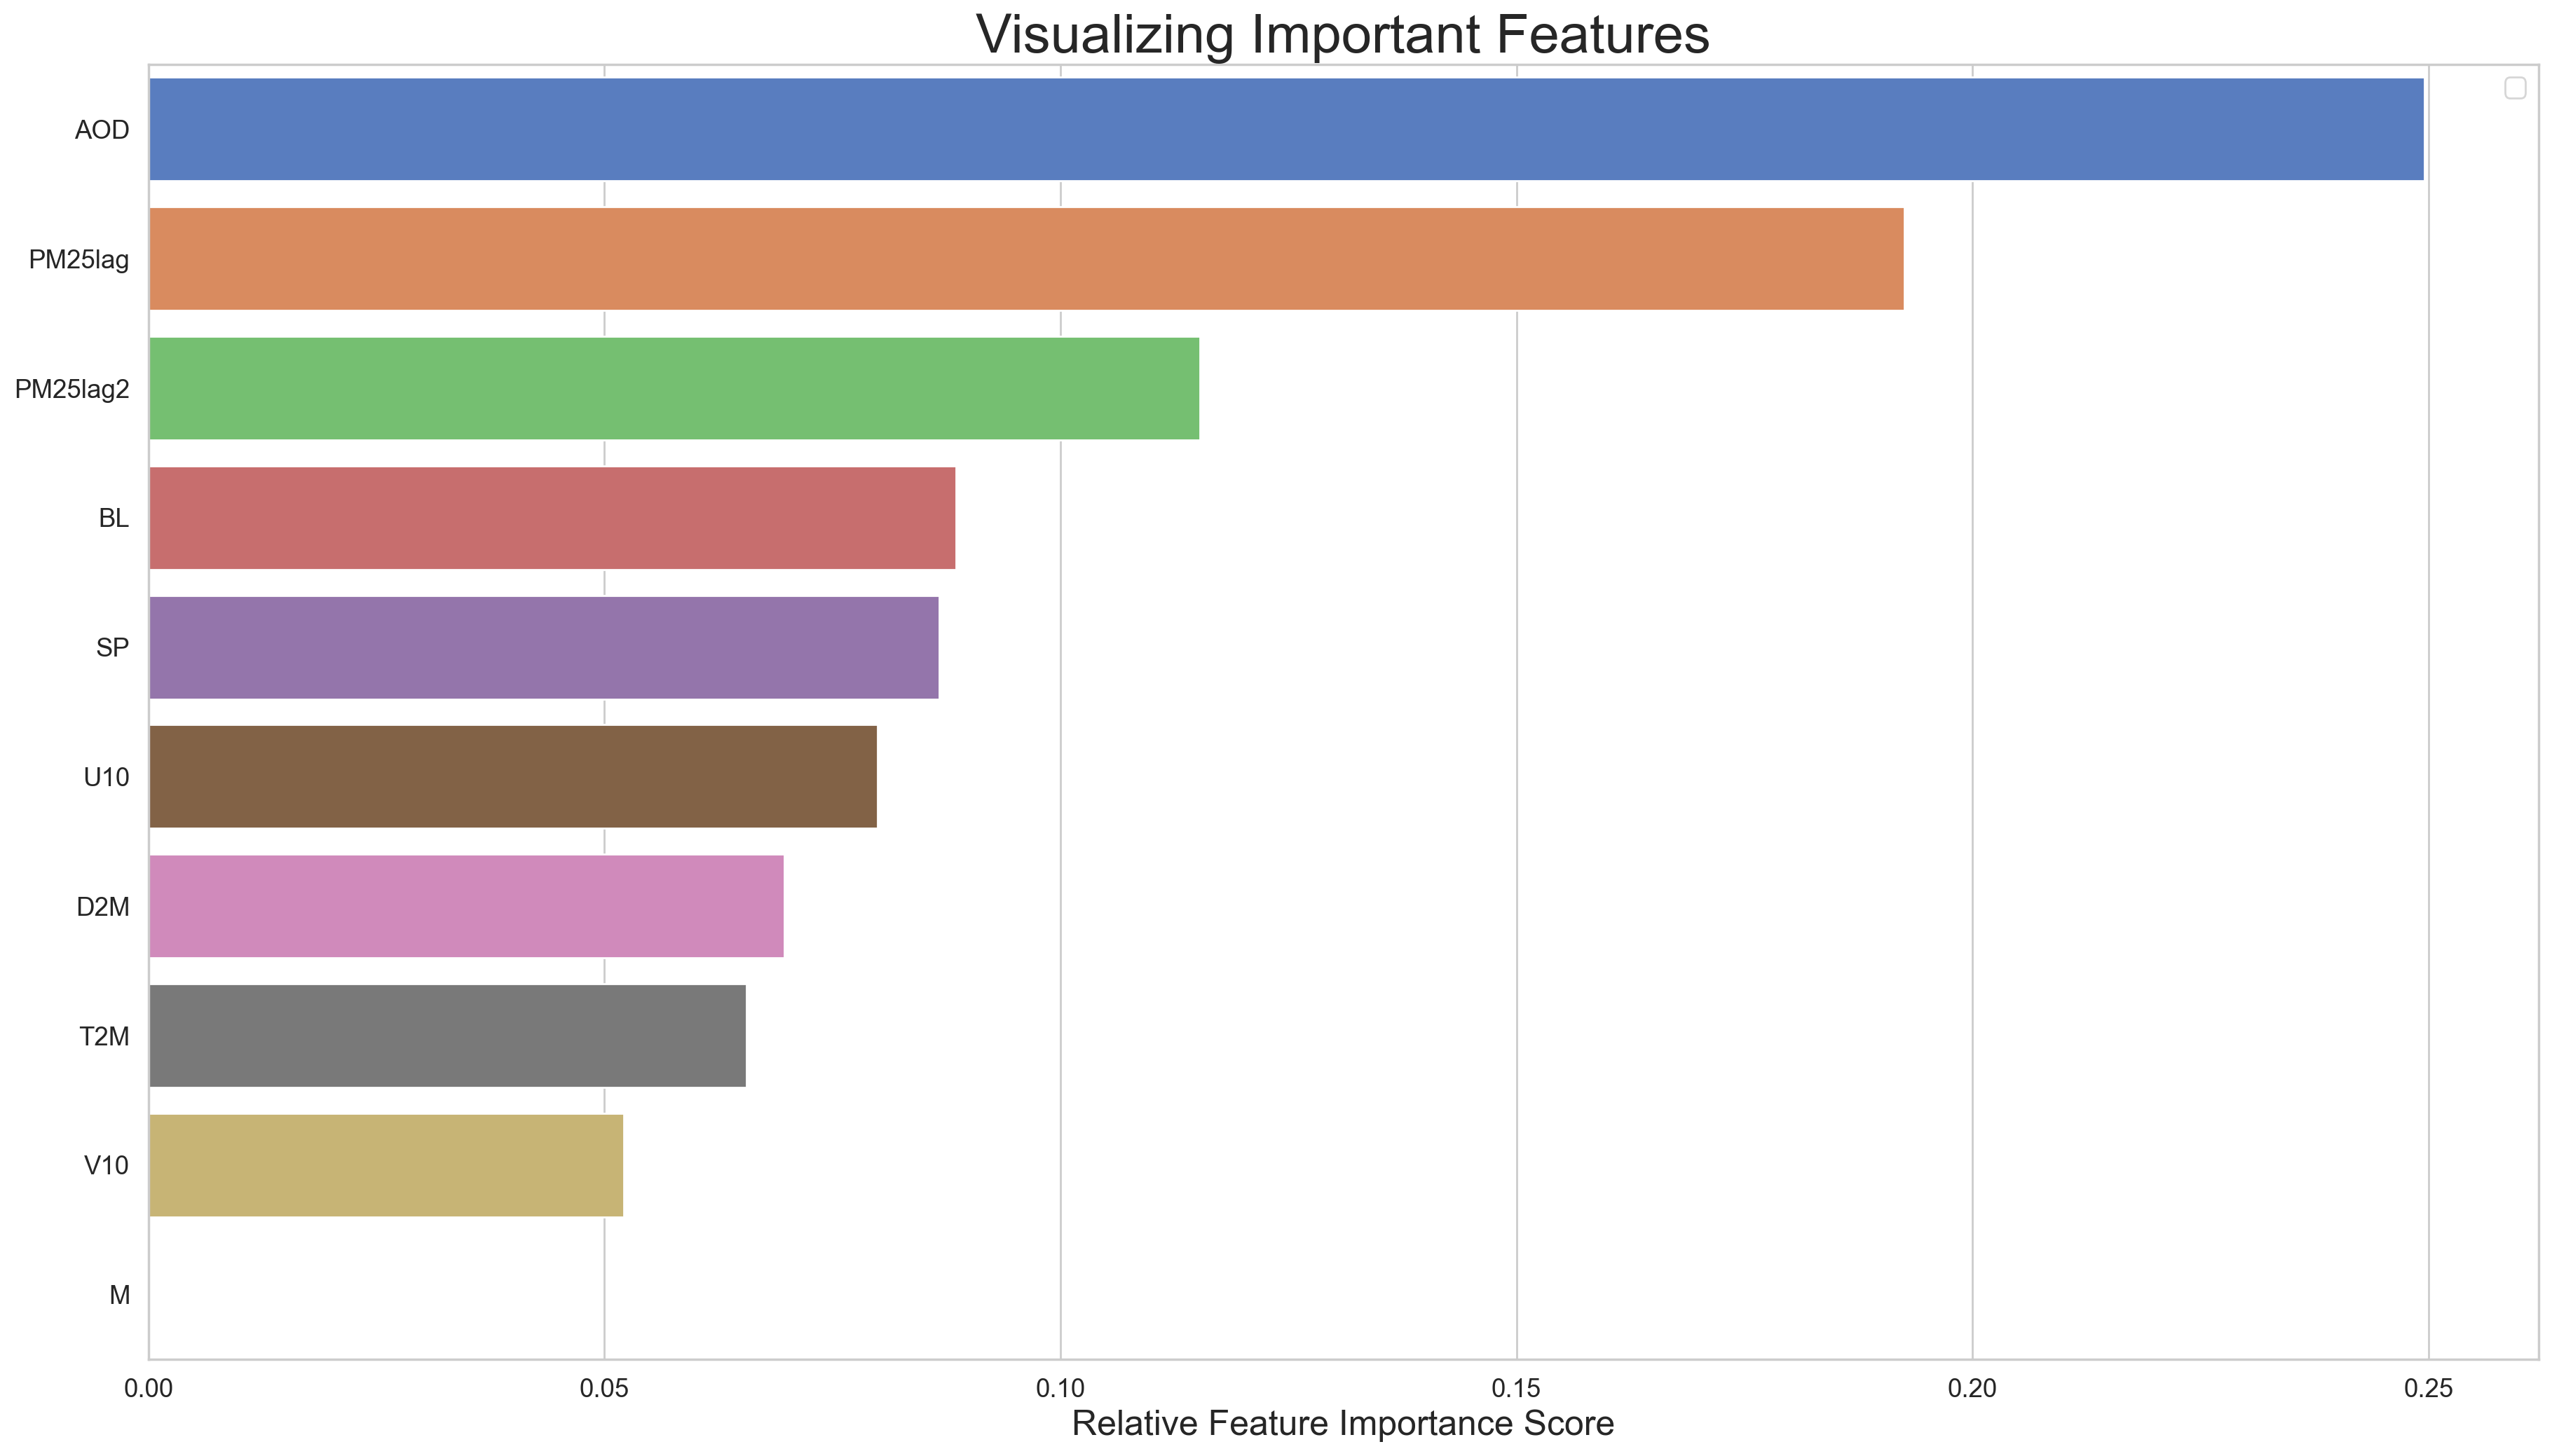

In [177]:


def average(nums, default=float('nan')):
    return sum(nums) / float(len(nums)) if nums else default
    
importances = model_rf.feature_importances_
indices = np.argsort(importances)

selected = selected_cols[:-1]

featureImpValues = []
feature_imp = (pd.Series(model_rf.feature_importances_,selected).tolist())    
featureImpValues.append(feature_imp)

feature_imp = []
feature_imp = [average(feature) for feature in zip(*featureImpValues)]
feature_sum = sum(feature_imp)
feature_labels=selected

features= pd.Series(feature_imp,feature_labels).sort_values(ascending=False)



print(features)
print(feature_sum)

# Creating a bar plot
sns.barplot(x=features, y=features.index)
# Add labels to your graph
plt.xlabel('Relative Feature Importance Score', fontsize=18)
#plt.ylabel('Features',fontsize=18)
plt.title("Visualizing Important Features",fontsize=28)
plt.legend()
plt.show()



In [ ]:
#gradient boost regressor
p_gb = {'n_estimators': 100, 'max_depth':5, 'min_samples_split': 4,'learning_rate': 0.05, 'loss': 'squared_error', 'random_state': RANDOM_SEED}
model_gb = GradientBoostingRegressor(**p_gb) 
model_gb.fit(X_train,y_train)
y_pred = model_gb.predict(X_test)
df_performance = df_performance.append(performance(model_gb, y_test, y_pred))



In [179]:
df_performance


,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634
0,SVR,0.808786,4.175466,2.043396,0.078769
0,RandomForestRegressor,0.838557,3.823404,1.955353,0.156444
0,GradientBoostingRegressor,0.839461,4.010280,2.002568,0.115214


In [ ]:
#xtreme gradient boost regressor
p_xgb = {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.03, 'random_state': 0 }
model_xgb = XGBRegressor(**p_xgb)
model_xgb.fit(X_train,y_train)
y_pred = model_xgb.predict(X_test)
df_performance = df_performance.append(performance(model_xgb, y_test, y_pred))

In [181]:
df_performance


,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634
0,SVR,0.808786,4.175466,2.043396,0.078769
0,RandomForestRegressor,0.838557,3.823404,1.955353,0.156444
0,GradientBoostingRegressor,0.839461,4.010280,2.002568,0.115214
0,XGBRegressor,0.836311,3.730701,1.931502,0.176897


In [ ]:
#xtreme gradient boost regressor
p_knn = {'n_neighbors': 25}
model_knn = KNeighborsRegressor(**p_knn)
model_knn.fit(X_train,y_train)
y_pred = model_knn.predict(X_test)
df_performance = df_performance.append(performance(model_knn, y_test, y_pred))

In [183]:
df_performance


,Model,MAE,MSE,RMSE,R2
0,LinearRegression,0.898177,4.099028,2.024606,0.095634
0,SVR,0.808786,4.175466,2.043396,0.078769
0,RandomForestRegressor,0.838557,3.823404,1.955353,0.156444
0,GradientBoostingRegressor,0.839461,4.010280,2.002568,0.115214
0,XGBRegressor,0.836311,3.730701,1.931502,0.176897
0,KNeighborsRegressor,0.842160,4.078408,2.019507,0.100183


In [54]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
y_pred = rf_random.predict(X_test)
df_performance = df_performance.append(performance(rf_random, y_test, y_pred))

In [41]:


rf_random.best_params_



{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}